# Forecasting Analysis

This summary notebook explores the rental growth of specific regions, and aims to predict the growth going into the future. The notebook runs a linear regression model accoutning for various time sensitive features.

It uses the external prices curated dataset.

In [1]:
import pandas as pd
import numpy as np

### Download and filter

In [5]:
curated_raw = pd.read_csv("../../../data/3. curated/external prices.csv", index_col=0)
print(curated_raw.shape)

(6228, 179)


In [6]:
def filter_frame(df, type=False, start_year=False, end_year=False):
    df_mask = pd.Series(data=True, index=df.index)
    if (type):
        df_mask = df_mask & (df["housing: type"] == type)
    
    if (start_year):
        df_mask = df_mask & (df["year groups"] >= start_year)
    if (end_year):
        df_mask = df_mask & (df["year groups"] <= end_year)
    
    return df[df_mask]

In [7]:
def filter_columns(df, find=[], avoid=[], require_all=False):
    curr_columns = df.columns
    
    # filter any columns that contain the find_sub
    if (find):
        if (not require_all):
            curr_columns = [column for column in curr_columns if any(sub in column for sub in find)]
        else:
            curr_columns = [column for column in curr_columns if all(sub in column for sub in find)]

    # avoid any columns that contain the avoid_sub
    curr_columns = [column for column in curr_columns if all(not sub in column for sub in avoid)]

    return curr_columns

FEATURES = filter_columns(curated_raw, find=["economic:"], avoid=["%", "gdp quarterly"]) + \
           filter_columns(curated_raw, find=["housing:"]) + \
           filter_columns(curated_raw, find=["overseas:"]) + \
           filter_columns(curated_raw, find=["population:"]) + \
           filter_columns(curated_raw, find=["relationships:"]) + \
           filter_columns(curated_raw, find=["studying:"], avoid=["PT", "FT"]) + \
           filter_columns(curated_raw, find=["distance:"]) + \
           ["suburbs", "year groups"]

curated = curated_raw[FEATURES]

print(curated.shape)
curated.head(3)

(6228, 119)


,economic: median income,economic: median age of earners,economic: gini coefficient,economic: variable interest rate,economic: gdp per capita quarterly,economic: trimmed mean quarterly,economic: number of earners,economic: net inflation,economic: variable interest rate growth,housing: type,...,studying: tertiary total (%),studying: tafe total (%),studying: primary government (%),studying: primary total (%),distance: crow distance to cbd,distance: distance to cbd,distance: crow distance to cbd inv,distance: distance to cbd inv,suburbs,year groups
0,63415.3,39.8,0.5565,6.3825,0.625,0.675,21731.8,1.044823,-0.070,flat,...,0.0637,0.0236,0.0336,0.0436,4.535857,6702.5,0.081735,0.211996,Albert Park-Middle Park-West St Kilda,2.0
1,63415.3,39.8,0.5565,6.6325,0.725,0.675,21731.8,1.073584,0.039,flat,...,0.0637,0.0236,0.0336,0.0436,4.535857,6702.5,0.081735,0.211996,Albert Park-Middle Park-West St Kilda,3.0
2,63415.3,39.8,0.5565,7.0700,0.475,0.675,21731.8,1.102315,0.066,flat,...,0.0637,0.0236,0.0336,0.0436,4.535857,6702.5,0.081735,0.211996,Albert Park-Middle Park-West St Kilda,4.0


## Plotting

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
Y_COLUMN = "housing: median growth avg"

def plot_subset(df, find=False, name="pairplot.png", display=True, root=False):
    y_column = Y_COLUMN
    if (root):
        y_column += " root"

    if (find):
        print(f"using \"{find}\" to filter")

        # get the filtered df
        df = df.copy()
        df = df[filter_columns(df, find=[find, y_column])]

    # print the shape and ask to continue
    response = input(f"frame has {df.shape[1]} columns, wish to proceed? (y)")
    if (response.lower() != "y"):
        return

    print(filter_columns(df, avoid=[y_column]))

    # graph
    sns.set_style('white')
    pairplot = sns.pairplot(df, y_vars=y_column, x_vars=df.columns, diag_kind=None)# #plot_kws={'alpha': 0.6})

    # save and show
    pairplot.figure.savefig(name + ".png", bbox_inches='tight', facecolor='white')
    if (display):
        plt.show()

### Distance

In [10]:
plot_subset(filter_frame(curated, type="house"), "distance:")
plot_subset(filter_frame(curated, type="flat"), "distance:")

using "distance:" to filter


using "distance:" to filter


### Housing

In [11]:
plot_subset(filter_frame(curated, type="house"), "housing:")
plot_subset(filter_frame(curated, type="flat"), "housing:")

using "housing:" to filter


using "housing:" to filter


In [12]:
print(filter_frame(curated, type="flat")[filter_columns(curated, find=["housing: "])].corr()[Y_COLUMN].sort_values())
print(filter_frame(curated, type="house")[filter_columns(curated, find=["housing: "])].corr()[Y_COLUMN].sort_values())

housing: previous price          -0.355480
housing: median                  -0.207310
housing: count growth            -0.147125
housing: count                   -0.144862
housing: previous count growth   -0.122718
housing: previous count          -0.101524
housing: previous growth          0.579776
housing: previous growth avg      0.732234
housing: median growth            0.918211
housing: median growth avg        1.000000
Name: housing: median growth avg, dtype: float64
housing: previous price          -0.255966
housing: median                  -0.162964
housing: previous count          -0.127517
housing: count                   -0.122916
housing: previous count growth   -0.107006
housing: count growth             0.022862
housing: previous growth          0.606603
housing: previous growth avg      0.761395
housing: median growth            0.894960
housing: median growth avg        1.000000
Name: housing: median growth avg, dtype: float64


/tmp/ipykernel_111039/1189150039.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(filter_frame(curated, type="flat")[filter_columns(curated, find=["housing: "])].corr()[Y_COLUMN].sort_values())
/tmp/ipykernel_111039/1189150039.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(filter_frame(curated, type="house")[filter_columns(curated, find=["housing: "])].corr()[Y_COLUMN].sort_values())


### Population (not total)

In [13]:
POP_COLUMNS = filter_columns(curated, find=["population: ", "growth"], require_all=True) + filter_columns(curated, find=["housing: median growth"])

plot_subset(filter_frame(curated, type="house")[POP_COLUMNS], name="population house")
plot_subset(filter_frame(curated, type="flat")[POP_COLUMNS], name="population flat")

In [14]:
print(filter_frame(curated, type="flat", start_year=22, end_year=23)[POP_COLUMNS].corr()["housing: median growth"].sort_values())
print("\n")
print(filter_frame(curated, type="house", start_year=22, end_year=23)[POP_COLUMNS].corr()["housing: median growth"].sort_values())

population: 65-69 growth     -0.012840
population: 50-54 growth      0.030216
population: 60-69 growth      0.070893
population: 0-4 growth        0.109553
population: 60-64 growth      0.111986
population: 70-74 growth      0.113121
population: 80-84 growth      0.114920
population: 50-59 growth      0.117370
population: 0-9 growth        0.142729
population: 75-79 growth      0.146165
population: 5-9 growth        0.152826
population: 55-59 growth      0.156595
population: 70-79 growth      0.190870
population: 80-89 growth      0.203963
population: 85+ growth        0.205900
population: 45-49 growth      0.272578
population: 10-14 growth      0.281404
population: 40-44 growth      0.366014
population: 35-39 growth      0.414083
population: 15-19 growth      0.416585
population: 40-49 growth      0.417957
population: 20-24 growth      0.445861
population: 25-29 growth      0.513763
population: 30-34 growth      0.515767
population: 10-19 growth      0.520125
population: 30-39 growth 

### Population Total

In [15]:
POP_COLUMNS = filter_columns(curated, find=["population: ", "total"], require_all=True) + filter_columns(curated, find=["housing: median growth"])

plot_subset(filter_frame(curated, type="house")[POP_COLUMNS], name="population total house")
plot_subset(filter_frame(curated, type="flat")[POP_COLUMNS], name="population total flat")

In [16]:
print(filter_frame(curated, type="flat")[POP_COLUMNS].corr()["housing: median growth"].sort_values())
print("\n")
print(filter_frame(curated, type="house")[POP_COLUMNS].corr()["housing: median growth"].sort_values())

population: total            -0.029168
population: total growth      0.249894
housing: median growth avg    0.918211
housing: median growth        1.000000
Name: housing: median growth, dtype: float64


population: total            -0.066097
population: total growth      0.246820
housing: median growth avg    0.894960
housing: median growth        1.000000
Name: housing: median growth, dtype: float64


### Studying

In [17]:
STUDY_COLUMNS = filter_columns(curated, find=["study", "%"], require_all=True) + filter_columns(curated, find=["housing: median growth"])

plot_subset(filter_frame(curated, type="house", start_year=22, end_year=23)[STUDY_COLUMNS], name="study house")
plot_subset(filter_frame(curated, type="flat", start_year=22, end_year=23)[STUDY_COLUMNS], name="study flat")

In [18]:
print(filter_frame(curated, type="flat")[STUDY_COLUMNS].corr()["housing: median growth"].sort_values())
print("\n")
print(filter_frame(curated, type="house")[STUDY_COLUMNS].corr()["housing: median growth"].sort_values())

studying: tertiary total (%)         -0.034239
studying: primary other (%)          -0.020106
studying: tafe total (%)             -0.008364
studying: secondary total (%)         0.011617
studying: secondary government (%)    0.021185
studying: secondary catholic (%)      0.023574
studying: primary catholic (%)        0.025759
studying: primary total (%)           0.028186
studying: primary government (%)      0.031979
studying: preschool (%)               0.032842
housing: median growth avg            0.918211
housing: median growth                1.000000
Name: housing: median growth, dtype: float64


studying: secondary total (%)        -0.033728
studying: tertiary total (%)         -0.028062
studying: primary other (%)          -0.019719
studying: primary total (%)          -0.017587
studying: secondary government (%)   -0.017443
studying: primary government (%)     -0.009900
studying: secondary catholic (%)     -0.008741
studying: primary catholic (%)       -0.006449
studying: pre

### Relationships

In [19]:
RELATIONSHIPS_COLUMNS = filter_columns(curated, find=["relationships", "%"], require_all=True) + filter_columns(curated, find=["housing: median growth"])

plot_subset(filter_frame(curated, type="house", start_year=22, end_year=23)[RELATIONSHIPS_COLUMNS], name="relationships house")
plot_subset(filter_frame(curated, type="flat", start_year=22, end_year=23)[RELATIONSHIPS_COLUMNS], name="relationships flat")

In [21]:
print(filter_frame(curated, type="flat", start_year=22, end_year=23)[RELATIONSHIPS_COLUMNS].corr()["housing: median growth"].sort_values())
print("\n")
print(filter_frame(curated, type="house", start_year=22, end_year=23)[RELATIONSHIPS_COLUMNS].corr()["housing: median growth"].sort_values())

relationships: non dependent child (%)        -0.323492
relationships: married (%)                    -0.298578
relationships: dependent student (%)          -0.259016
relationships: lone parents (%)               -0.244314
relationships: other related individual (%)    0.032722
relationships: defacto (%)                     0.210890
relationships: lone persons (%)                0.309547
relationships: group household (%)             0.340148
housing: median growth avg                     0.926024
housing: median growth                         1.000000
Name: housing: median growth, dtype: float64


relationships: group household (%)            -0.115638
relationships: defacto (%)                    -0.112123
relationships: dependent student (%)          -0.051615
relationships: lone persons (%)                0.001877
relationships: other related individual (%)    0.045534
relationships: married (%)                     0.051738
relationships: non dependent child (%)         0.068599
r

### Economic

In [22]:
ECONOMIC_COLUMNS = filter_columns(curated, find=["economic: "], require_all=True) + filter_columns(curated, find=["housing: median growth"])

plot_subset(filter_frame(curated, type="house", start_year=22, end_year=23)[ECONOMIC_COLUMNS], name="relationships house")
plot_subset(filter_frame(curated, type="flat", start_year=22, end_year=23)[ECONOMIC_COLUMNS], name="relationships flat")

In [24]:
print(filter_frame(curated, type="flat", start_year=22, end_year=23)[ECONOMIC_COLUMNS].corr()["housing: median growth"].sort_values())
print("\n")
print(filter_frame(curated, type="house", start_year=22, end_year=23)[ECONOMIC_COLUMNS].corr()["housing: median growth"].sort_values())

economic: gdp per capita quarterly        -0.552718
economic: trimmed mean quarterly          -0.552718
economic: median age of earners           -0.214159
economic: number of earners               -0.063016
economic: median income                   -0.025452
economic: gini coefficient                 0.185838
economic: variable interest rate           0.552718
economic: net inflation                    0.552718
economic: variable interest rate growth    0.552718
housing: median growth avg                 0.926024
housing: median growth                     1.000000
Name: housing: median growth, dtype: float64


economic: gdp per capita quarterly        -0.363385
economic: trimmed mean quarterly          -0.363385
economic: median income                   -0.212123
economic: gini coefficient                -0.064385
economic: number of earners                0.070352
economic: median age of earners            0.084169
economic: variable interest rate           0.363385
economic: variabl

### Overseas

In [25]:
OVERSEAS_COLUMNS = filter_columns(curated, find=["oversea"], require_all=True) + filter_columns(curated, find=["housing: median growth"])

plot_subset(filter_frame(curated, type="house", start_year=22, end_year=23)[OVERSEAS_COLUMNS], name="overseas house")
plot_subset(filter_frame(curated, type="flat", start_year=22, end_year=23)[OVERSEAS_COLUMNS], name="overseas flat")

## Outliers

In [26]:
# filter out spots less than 200 (to noisy)
curated = curated[curated["housing: count"] >= 200]

## Transformations

### Cubed root (not implemented at the moment, as just copy again in "Log")

In [27]:
# do the log transforms
ROOT_FEATURES = ["housing: median growth"]

curated_final = curated.copy()
for feature in ROOT_FEATURES:
    curated_final.loc[:, feature + " root"] = curated[feature].apply(np.cbrt)

plot_subset(filter_frame(curated_final, type="house")[filter_columns(curated_final, find=["root", "housing:"])], name="root transformation housing", root=True)
plot_subset(filter_frame(curated_final, type="flat")[filter_columns(curated_final, find=["root", "housing:"])], name="root transformation flat", root=True)

### Log

In [30]:
[x for x in curated.columns if "(%)" in x]

['relationships: other related individual (%)',
 'relationships: dependent student (%)',
 'relationships: non dependent child (%)',
 'relationships: lone parents (%)',
 'relationships: defacto (%)',
 'relationships: lone persons (%)',
 'relationships: group household (%)',
 'relationships: married (%)',
 'studying: secondary catholic (%)',
 'studying: preschool (%)',
 'studying: primary other (%)',
 'studying: primary catholic (%)',
 'studying: secondary government (%)',
 'studying: secondary total (%)',
 'studying: tertiary total (%)',
 'studying: tafe total (%)',
 'studying: primary government (%)',
 'studying: primary total (%)']

In [29]:
# do the log transforms
LOG_FEATURES = ["housing: previous count", "housing: count"] + \
               ["studying: tertiary total (%)", "studying: primary other (%)", "studying: tafe total (%)"] + \
               ["economic: number of earners"] + \
               ["population: total"] + \
               ["overseas: 5 years (%)"] + \
               ["distance: distance to cbd", "distance: crow distance to cbd"]

curated_final = curated.copy()
for feature in LOG_FEATURES:
    curated_final.loc[:, feature + " log"] = curated[feature].apply(np.log)
    curated_final.rename(columns={feature: feature + " norm"}, inplace=True)


plot_subset(filter_frame(curated_final, type="house")[filter_columns(curated_final, find=["log", "housing: median"])], name="transformation housing", root=False)
plot_subset(filter_frame(curated_final, type="flat")[filter_columns(curated_final, find=["log", "housing: median"])], name="transformation flat", root=False)

KeyError: 'overseas: 5 years (%)'

In [ ]:
print(filter_frame(curated_final, type="flat", start_year=22, end_year=23)[filter_columns(curated_final, find=["log", "housing: median"])].corr()["housing: median growth"].sort_values())
print("\n")
print(filter_frame(curated_final, type="house", start_year=22, end_year=23)[filter_columns(curated_final, find=["log", "housing: median"])].corr()["housing: median growth"].sort_values())

distance: crow distance to cbd log   -0.215810
distance: distance to cbd log        -0.192655
studying: primary other (%) log      -0.154974
economic: number of earners log      -0.047088
population: total persons log        -0.037280
studying: tafe total (%) log          0.226281
housing: count log                    0.232566
studying: tertiary total (%) log      0.232669
overseas: 5 years (%) log             0.266609
housing: previous count log           0.295759
housing: median                       0.481114
housing: median growth avg            0.926024
housing: median growth                1.000000
Name: housing: median growth, dtype: float64


studying: tertiary total (%) log     -0.197672
overseas: 5 years (%) log            -0.083264
housing: median                      -0.071006
studying: primary other (%) log       0.013640
housing: count log                    0.016711
economic: number of earners log       0.031581
housing: previous count log           0.050363
population: t

## Interaction

In [95]:
def get_interaction(df, interaction_pairs):
    # get all the interaction pairs
    for column_1, column_2 in interaction_pairs:
        new_name = f"interaction: ({column_1}) & ({column_2})"
        df[new_name] = df[column_1] * df[column_2]
    
    return df

In [96]:
POP_COLUMNS = filter_columns(curated_final, ["population: ", "growth", "0", "9"], ["interaction"], require_all=True) + filter_columns(curated_final, ["population:", "total"], ["norm", "interaction"], require_all=True)

# will get interaction between
# - all population growths and distance / median income
# - quarterly growths with distance / median income
# - all population growths and teritary
interaction_pairs = [(x, y) for x in filter_columns(curated_final, ["distance:", "economic: median income"], ["inv", "norm", "interaction"]) for y in POP_COLUMNS] + \
                    [(x, y) for x in filter_columns(curated_final, ["distance:", "economic: median income"], ["inv", "norm", "interaction"]) for y in ['economic: trimmed mean quarterly', 'economic: gdp per capita quarterly']] + \
                    [(x, y) for x in filter_columns(curated_final, ["studying:", "tertiary", "log"], ["interaction"], require_all=True) for y in POP_COLUMNS]

curated_final = get_interaction(curated_final, interaction_pairs)

In [97]:
INTERACTION_COLUMNS = filter_columns(curated_final, find=["interaction: ", "population", ": distance"], require_all=True) + filter_columns(curated_final, find=["housing: median growth"])

plot_subset(filter_frame(curated_final, type="house")[INTERACTION_COLUMNS], name="interaction house")
plot_subset(filter_frame(curated_final, type="flat")[INTERACTION_COLUMNS], name="interaction flat")

In [98]:
print(filter_frame(curated_final, type="flat")[INTERACTION_COLUMNS].corr()["housing: median growth"].sort_values())
print("\n")
print(filter_frame(curated_final, type="house")[INTERACTION_COLUMNS].corr()["housing: median growth"].sort_values())


interaction: (distance: distance to cbd log) & (population: 70-79 growth)           -0.036252
interaction: (distance: distance to cbd log) & (population: total persons log)       0.037565
interaction: (distance: distance to cbd log) & (population: 80-89 growth)            0.042079
interaction: (distance: distance to cbd log) & (population: 50-59 growth)            0.065393
interaction: (distance: distance to cbd log) & (population: 30-39 growth)            0.103052
interaction: (distance: distance to cbd log) & (population: 60-69 growth)            0.114543
interaction: (distance: distance to cbd log) & (population: 40-49 growth)            0.157679
interaction: (distance: distance to cbd log) & (population: 10-19 growth)            0.183080
interaction: (distance: distance to cbd log) & (population: 0-9 growth)              0.195254
interaction: (distance: distance to cbd log) & (population: total persons growth)    0.252431
interaction: (distance: distance to cbd log) & (population: 

## Fitting the model

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

##### Overftting

In [22]:
##### FOR OVERFITTING / TRENDS ###########

# include the following
# - information about the region that doesn't change (economic)
# - types of beds and the previous, price growth, count growth, log count, price
# - number of people overseas 5 years ago
# - population growth by each demographic
# - population total count log
# - percentage of the population studying and what not
FEATURES = filter_columns(curated_final, find=["housing"], avoid=["norm", "median growth", "housing: count", "housing: median"]) + \
           filter_columns(curated_final, find=["population:", "growth"], require_all=True) + \
           filter_columns(curated_final, find=["population", "total", "log"], require_all=True) + \
           filter_columns(curated_final, find=["overseas:", "log"], require_all=True) + \
           filter_columns(curated_final, find=["economic"], avoid=["growth", "inflation", "norm", "interest"]) + \
           filter_columns(curated_final, find=["studying:", "(%)"], avoid=["norm"], require_all=True)
CAT_FEATURES = ["housing: type"]

len(FEATURES)

126

##### Interaction

In [100]:
##### FOR all variables that can actually work ###########

# include the following
# - information about the region that doesn't change (economic)
# - types of beds and the previous, price growth, count growth, log count, price
# - number of people overseas 5 years ago
# - population growth by each demographic
# - population total count log
# - percentage of the population studying and what not
FEATURES = filter_columns(curated_final, find=["housing"], avoid=["norm", "median growth", "housing: count", "housing: median", "interaction", "avg"]) + \
           POP_COLUMNS + \
           filter_columns(curated_final, find=["economic", "quarterly"], avoid=["distance"], require_all=True) + \
           filter_columns(curated_final, find=["interaction", "population"], avoid=["distance"], require_all=True)
           

CAT_FEATURES = ["housing: type"]

len(FEATURES)

42

##### No interaction reasonable

In [471]:
##### FOR all variables that can actually work ###########

# include the following
# - information about the region that doesn't change (economic)
# - types of beds and the previous, price growth, count growth, log count, price
# - number of people overseas 5 years ago
# - population growth by each demographic
# - population total count log
# - percentage of the population studying and what not
FEATURES = filter_columns(curated_final, find=["housing"], avoid=["norm", "median growth", "housing: count", "housing: median", "interaction"]) + \
           POP_COLUMNS + \
           filter_columns(curated_final, find=["economic", "quarterly"], avoid=["crow"], require_all=True)

CAT_FEATURES = ["housing: type"]

len(FEATURES)

23

In [472]:
FEATURES

['housing: type',
 'housing: previous growth',
 'housing: previous price',
 'housing: previous count growth',
 'housing: previous growth avg',
 'housing: previous count log',
 'population: 0-9 growth',
 'population: 10-19 growth',
 'population: 20-29 growth',
 'population: 30-39 growth',
 'population: 40-49 growth',
 'population: 50-59 growth',
 'population: 60-69 growth',
 'population: 70-79 growth',
 'population: 80-89 growth',
 'population: total persons growth',
 'population: total persons log',
 'economic: trimmed mean quarterly',
 'economic: gdp per capita quarterly',
 'interaction: (economic: median income) & (economic: trimmed mean quarterly)',
 'interaction: (economic: median income) & (economic: gdp per capita quarterly)',
 'interaction: (distance: distance to cbd log) & (economic: trimmed mean quarterly)',
 'interaction: (distance: distance to cbd log) & (economic: gdp per capita quarterly)']

##### No population growth everywhere

In [414]:
##### FOR very small model, only big population, economic and more ###########

# include the following
# - information about the region that doesn't change (economic)
# - types of beds and the previous, price growth, count growth, log count, price
# - number of people overseas 5 years ago
# - population growth by each demographic
# - population total count log
# - percentage of the population studying and what not
FEATURES = filter_columns(curated_final, find=["housing"], avoid=["norm", "median growth", "housing: count", "housing: median"]) + \
           filter_columns(curated_final, find=["economic", "quarterly"], require_all=True) + \
           filter_columns(curated_final, find=["population", "total", "log"], require_all=True)

CAT_FEATURES = ["housing: type"]

len(FEATURES)

9

##### Smallest baseline

In [258]:
##### Smallest baseline ###########

# only includes:
# - previous growth rate
# - inflation
FEATURES = filter_columns(curated_final, find=["housing", "previous growth"], require_all=True) + \
           filter_columns(curated_final, find=["economic", "quarterly", "trimmed"], require_all=True) + \
           ["housing: type"]

CAT_FEATURES = ["housing: type"]

len(FEATURES)

4

### Functions

In [25]:
def calculate_aic(model, X, y):
    """
    Calculate the Akaike Information Criterion (AIC) for a given scikit-learn model.

    Parameters:
    - model: A fitted scikit-learn model that implements the `predict` method.
    - X: Features (numpy array or pandas DataFrame) used for fitting the model.
    - y: True target values (numpy array or pandas Series).

    Returns:
    - aic: The Akaike Information Criterion value.
    """
    # Ensure the model has been fitted
    if not hasattr(model, 'predict'):
        raise ValueError("The model must implement the `predict` method and be fitted.")

    # Number of observations
    n = len(y)

    # Number of parameters (coefficients + intercept)
    if hasattr(model, 'coef_'):
        # Linear models (e.g., LinearRegression)
        k = model.coef_.shape[0] + 1  # Coefficients + Intercept
    else:
        # Other models
        k = len(model.get_params())

    # Predicted values
    y_pred = model.predict(X)

    # Calculate residual sum of squares
    residual_sum_of_squares = np.sum((y - y_pred) ** 2)

    # Calculate AIC
    aic = n * np.log(residual_sum_of_squares / n) + 2 * k
    return aic

In [26]:
def forward_selection_with_validation(X_select_train, y_select_train, X_select_val, y_select_val, validation_size=0.2, random_state=42, use_aic=True):
    """
    Perform forward selection using a validation set to choose the best set of features for linear regression.
    
    Args:
    X: Features (DataFrame)
    y: Target variable (Series)
    validation_size: Fraction of data to use as validation set (default 0.2)
    random_state: Random seed for reproducibility (default 42)
    
    Returns:
    best_features: List of selected features based on validation set performance
    final_model: Trained linear regression model using the selected features
    """

    # Rename
    X_train, y_train, X_val, y_val = X_select_train, y_select_train, X_select_val, y_select_val
    
    # Initialize variables
    initial_features = []
    remaining_features = list(X_train.columns)
    best_features = []
    best_score = float('inf')  # Start with a very high RMSE
    
    # Iterate through all features to add one by one
    while remaining_features:
        scores_with_candidates = []
        
        # Try adding each remaining feature to the model
        for candidate in remaining_features:
            # Features to include in the model
            features_to_test = initial_features + [candidate]
            
            # Fit a linear regression model using the current feature set
            model = LinearRegression()
            model.fit(X_train[features_to_test], y_train)
            
            if (not use_aic):
                # Predict and calculate RMSE on the validation set
                y_val_pred = model.predict(X_val[features_to_test])
                rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

                # Store the result: (rmse, feature_name)
                scores_with_candidates.append((rmse, candidate))
                
            else:
                # get the AIC
                aic = calculate_aic(model, X_val[features_to_test], y_val)
                scores_with_candidates.append((aic, candidate))
        
        # Sort by RMSE, select the best candidate feature
        scores_with_candidates.sort(reverse=False)
        best_new_score, best_new_feature = scores_with_candidates[0]
        
        # If the score improves, update the best features list
        if best_new_score < best_score:
            initial_features.append(best_new_feature)
            remaining_features.remove(best_new_feature)
            best_features = initial_features.copy()
            best_score = best_new_score
            if (use_aic):
                print(f"Selected '{best_new_feature}' with AIC: {best_new_score:.4f}")
            else:
                print(f"Selected '{best_new_feature}' with RMSE: {best_new_score:.4f}")
        else:
            break  # Stop if adding a new feature doesn't improve the score
    
    return best_features, best_score


In [27]:
def get_mask(df, start_year, end_year=False):
    if (not end_year):
        mask = df["year groups"] == start_year
    else:
        mask = ((df["year groups"] >= start_year) &
                (df["year groups"] <= end_year))
    return mask

In [28]:
TEST_COLUMN = "housing: median growth"

def get_data(df, start_year, end_year, test_year, features):

    # remove `all`` properties
    df_filt = df.copy()[(df["housing: type"] == "house")] #& (curated_final["housing: beds"] == "3")]
    not_na_mask = ~df_filt[features + [TEST_COLUMN]].isna().any(axis=1)

    # test mask
    test_mask = get_mask(df_filt, test_year) & not_na_mask

    # get the mask forward selection
    selection_train_masks = [get_mask(df_filt, start_year, end_year=end_year-1) & not_na_mask for start_year in range(start_year, end_year)]
    selection_val_mask = get_mask(df_filt, end_year) & not_na_mask

    # get the train test features
    X = df_filt[features]
    y = df_filt[TEST_COLUMN]

    # Step 3: One-Hot Encode the categorical features
    X = pd.get_dummies(X, columns=list(set(CAT_FEATURES) & set(features)), drop_first=True)

    # split the train and test
    X_train, y_train, X_test, y_test = X[selection_train_masks[0]], y[selection_train_masks[0]], X[test_mask], y[test_mask]

    # store in dictionary
    data_dict = {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test, 
        "y_test": y_test,
        "X": X,
        "y": y,
        "train_masks": selection_train_masks,
        "val_mask": selection_val_mask
        }
    return data_dict

In [29]:
def get_train_test(df, start_year, end_year, test_year, features):
    data_dict = get_data(df, start_year, end_year, test_year, features)

    # get the datasets
    train_mask = data_dict["train_masks"][0]
    val_mask = data_dict["val_mask"]
    X = data_dict["X"]
    y = data_dict["y"]
    X_test = data_dict["X_test"]
    y_test = data_dict["y_test"]

    # split the validation
    X_select_train, y_select_train, X_select_val, y_select_val = X[train_mask], y[train_mask], X[val_mask], y[val_mask]

    # get the best features
    best_features, score = forward_selection_with_validation(X_select_train, y_select_train, X_select_val, y_select_val, use_aic=True)

    # get the best feature mask and split
    X_train = X[train_mask][best_features]
    y_train = y[train_mask]
    X_test = X_test[best_features]

    return X_train, y_train, X_test, y_test, best_features

### Every batch

In [128]:
from collections import Counter

TRAINING_SIZE = 3

max_year = int(curated_final["year groups"].max())
min_year = int(curated_final["year groups"].min())

best_features_list = []
for curr_start_year in range(min_year, max_year-TRAINING_SIZE+1):
    print("up to", curr_start_year)

    # get the data dict
    _a, _b, _c, _d, best_features = get_train_test(curated_final, curr_start_year, curr_start_year+TRAINING_SIZE, curr_start_year+TRAINING_SIZE+1, FEATURES)

    best_features_list.append(best_features)

flattened_features = [item for sublist in best_features_list for item in sublist]
features_dict = dict(Counter(flattened_features))
sorted(features_dict.items(), key=lambda x: x[1])

up to 2
Selected 'population: total persons log' with AIC: -1105.7850
Selected 'interaction: (economic: median income) & (population: 80-89 growth)' with AIC: -1105.9321
up to 3
Selected 'economic: gdp per capita quarterly' with AIC: -1049.4122
Selected 'population: 80-89 growth' with AIC: -1053.3441
Selected 'housing: previous count growth' with AIC: -1055.2310
Selected 'interaction: (studying: tertiary total (%) log) & (population: 70-79 growth)' with AIC: -1057.6565
up to 4
Selected 'economic: trimmed mean quarterly' with AIC: -875.6259
Selected 'housing: previous growth' with AIC: -881.3274
Selected 'housing: previous count log' with AIC: -882.0787
up to 5
Selected 'economic: trimmed mean quarterly' with AIC: -883.0560
Selected 'interaction: (studying: tertiary total (%) log) & (population: total persons log)' with AIC: -908.1014
Selected 'housing: previous growth' with AIC: -916.4927
Selected 'population: total persons log' with AIC: -918.8057
Selected 'interaction: (economic: med

[('population: 80-89 growth', 1),
 ('interaction: (studying: tertiary total (%) log) & (population: 70-79 growth)',
  1),
 ('interaction: (studying: tertiary total (%) log) & (population: 30-39 growth)',
  1),
 ('interaction: (studying: tertiary total (%) log) & (population: 80-89 growth)',
  1),
 ('interaction: (studying: tertiary total (%) log) & (population: 0-9 growth)',
  1),
 ('interaction: (economic: median income) & (population: 40-49 growth)', 1),
 ('population: total persons growth', 1),
 ('interaction: (economic: median income) & (population: 10-19 growth)', 1),
 ('interaction: (economic: median income) & (population: 80-89 growth)', 2),
 ('interaction: (economic: median income) & (population: 30-39 growth)', 2),
 ('interaction: (studying: tertiary total (%) log) & (population: 50-59 growth)',
  2),
 ('economic: gdp per capita quarterly', 3),
 ('interaction: (economic: median income) & (population: 0-9 growth)', 3),
 ('interaction: (studying: tertiary total (%) log) & (popul

In [131]:
COUNT_THRESH = 4

[column_key for column_key, count in features_dict.items() if count >= COUNT_THRESH]

['population: total persons log',
 'housing: previous count growth',
 'economic: trimmed mean quarterly',
 'housing: previous growth',
 'housing: previous count log',
 'interaction: (studying: tertiary total (%) log) & (population: total persons log)',
 'interaction: (economic: median income) & (economic: trimmed mean quarterly)',
 'housing: previous price']

In [132]:
ADD = 0

START_YEAR = 0 + ADD
END_YEAR = 4 + ADD
TEST_YEAR = 5 + ADD

SELECT_FEATURES_NO = [column_key for column_key, count in features_dict.items() if count >= COUNT_THRESH]

dd = get_data(curated_final, START_YEAR, END_YEAR, TEST_YEAR, SELECT_FEATURES_NO)
X_train, y_train, X_test, y_test = dd["X_train"], dd["y_train"], dd["X_test"], dd["y_test"]

In [136]:
r2_list = []
r2_base_list = []
#r2_zero_list = []

for i in range(2, 17):
    print(i)
    ADD = i

    START_YEAR = 0 + ADD
    END_YEAR = 4 + ADD
    TEST_YEAR = 5 + ADD

    SELECT_FEATURES_NO = [column_key for column_key, count in features_dict.items() if count >= COUNT_THRESH]

    dd = get_data(curated_final, START_YEAR, END_YEAR, TEST_YEAR, SELECT_FEATURES_NO)
    X_train, y_train, X_test, y_test = dd["X_train"], dd["y_train"], dd["X_test"], dd["y_test"]

    r2, r2_base = evaluate(X_train, y_train, X_test, y_test, RRF=True)
    r2_list.append(r2)
    r2_base_list.append(r2_base)
    #r2_zero_list.append(r2_zero)

2
Random Forest Model Performance:
Testing  R^2: -3.4065, RMSE: 0.0750

Baseline Model (Median Predictor) Performance:
Testing  R^2: -2.2119, RMSE: 0.0641
3
Random Forest Model Performance:
Testing  R^2: -1.9427, RMSE: 0.0718

Baseline Model (Median Predictor) Performance:
Testing  R^2: -2.9722, RMSE: 0.0834
4
Random Forest Model Performance:
Testing  R^2: -0.7919, RMSE: 0.0393

Baseline Model (Median Predictor) Performance:
Testing  R^2: -0.8408, RMSE: 0.0398
5
Random Forest Model Performance:
Testing  R^2: -0.0830, RMSE: 0.0610

Baseline Model (Median Predictor) Performance:
Testing  R^2: -0.0016, RMSE: 0.0587
6
Random Forest Model Performance:
Testing  R^2: -0.0957, RMSE: 0.0287

Baseline Model (Median Predictor) Performance:
Testing  R^2: -1.0063, RMSE: 0.0388
7
Random Forest Model Performance:
Testing  R^2: -8.7245, RMSE: 0.0861

Baseline Model (Median Predictor) Performance:
Testing  R^2: -2.8746, RMSE: 0.0544
8
Random Forest Model Performance:
Testing  R^2: -2.5771, RMSE: 0.0396

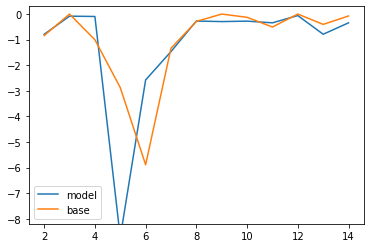

In [137]:
plt.plot(list(range(len(r2_list))[2:]), r2_list[2:], label="model")
plt.plot(list(range(len(r2_list))[2:]), r2_base_list[2:], label="base")
plt.ylim((-8.2, 0.3))
plt.legend()

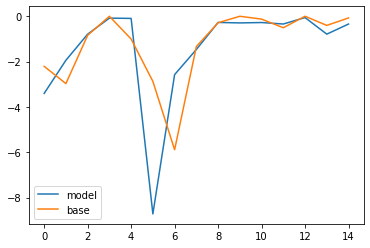

In [139]:
plt.plot(list(range(len(r2_list))), r2_list, label="model")
plt.plot(list(range(len(r2_list))), r2_base_list, label="base")
plt.legend()

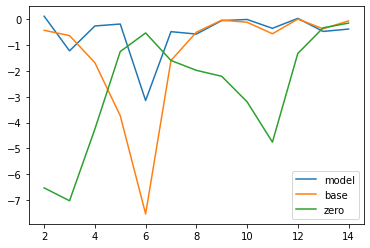

In [74]:
plt.plot(list(range(len(r2_list))[2:]), r2_list[2:], label="model")
plt.plot(list(range(len(r2_list))[2:]), r2_base_list[2:], label="base")
plt.plot(list(range(len(r2_list))[2:]), r2_zero_list[2:], label="zero")
plt.legend()

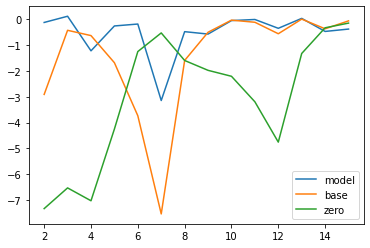

In [57]:
plt.plot(list(range(len(r2_list))[2:]), r2_list[2:], label="model")
plt.plot(list(range(len(r2_list))[2:]), r2_base_list[2:], label="base")
plt.plot(list(range(len(r2_list))[2:]), r2_zero_list[2:], label="zero")
plt.legend()

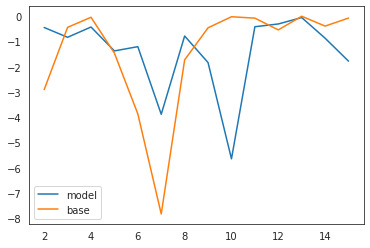

In [182]:
plt.plot(list(range(len(r2_list))[2:]), r2_list[2:], label="model")
plt.plot(list(range(len(r2_list))[2:]), r2_base_list[2:], label="base")
plt.legend()

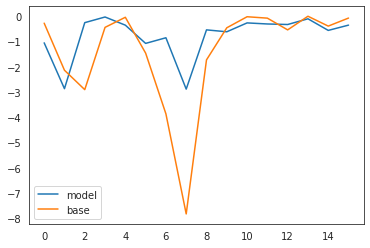

In [170]:
plt.plot(list(range(len(r2_list))), r2_list, label="model")
plt.plot(list(range(len(r2_list))), r2_base_list, label="base")
plt.legend()

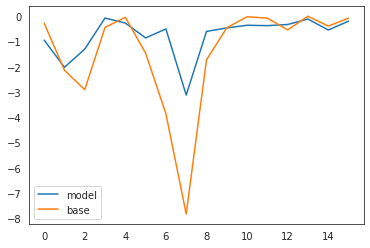

In [176]:
plt.plot(list(range(len(r2_list))), r2_list, label="model")
plt.plot(list(range(len(r2_list))), r2_base_list, label="base")
plt.legend()

### Evaluating

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

def evaluate_rrf(X_train, y_train, X_test, y_test):   
    # Train a Random Forest Regressor
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=8)
    rf_regressor.fit(X_train, y_train)

    # score the model
    y_test_pred = rf_regressor.predict(X_test)

    # scoring
    r2_test = r2_score(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f"Random Forest Model Performance:")
    print(f"Testing  R^2: {r2_test:.4f}, RMSE: {rmse_test:.4f}")

    # Baseline metrics (Median predictor)
    median_test_pred = np.full_like(y_test, np.median(y_train))
    median_r2_test = r2_score(y_test, median_test_pred)
    median_rmse_test = np.sqrt(mean_squared_error(y_test, median_test_pred))
    print(f"\nBaseline Model (Median Predictor) Performance:")
    print(f"Testing  R^2: {median_r2_test:.4f}, RMSE: {median_rmse_test:.4f}")

    return r2_test, median_r2_test

In [113]:
def evaluate(X_train, y_train, X_test, y_test, RRF=False):
    if (RRF):
        return evaluate_rrf(X_train, y_train, X_test, y_test)

    # train and test
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)

    # Predict target values using the test set
    y_pred = lin_reg.predict(X_test)

    # Calculate evaluation metrics
    mse_linear = mean_squared_error(y_test, y_pred)
    r2_linear = r2_score(y_test, y_pred)

    # baseline data2
    baseline_pred = [y_train.mean()] * len(y_test)

    # baseline score
    mse_baseline = mean_squared_error(y_test, baseline_pred)
    r2_baseline = r2_score(y_test, baseline_pred)

    # zero R
    zero = [0] * len(y_test)

    # baseline score
    mse_zero = mean_squared_error(y_test, zero)
    r2_zero = r2_score(y_test, zero)

    # Step 9: Print comparison results
    print(f"Linear Model - RMSE: {np.sqrt(mse_linear):.3f}, R-squared: {r2_linear:.3f}")
    print(f"Baseline Model - RMSE: {np.sqrt(mse_baseline):.3f}, R-squared: {r2_baseline:.3f}")
    print(f"Zero Model - RMSE: {np.sqrt(mse_zero):.3f}, R-squared: {r2_zero:.3f}")

    return r2_linear, r2_baseline, r2_zero

In [131]:
#coefficients_series = pd.Series(lin_reg.coef_, index=X_train.columns, name='Coefficient')
#coefficients_series

### Predictions

In [149]:
SELECT_FEATURES = ["housing: previous price", "housing: previous count growth", "housing: previous growth", "housing: previous count log"] + \
                  ["population: total persons log", "economic: trimmed mean quarterly"] + \
                  ["interaction: (studying: tertiary total (%) log) & (population: total persons log)", "interaction: (economic: median income) & (economic: trimmed mean quarterly)"]
SELECT_FEATURES

['housing: previous price',
 'housing: previous count growth',
 'housing: previous growth',
 'housing: previous count log',
 'population: total persons log',
 'economic: trimmed mean quarterly',
 'interaction: (studying: tertiary total (%) log) & (population: total persons log)',
 'interaction: (economic: median income) & (economic: trimmed mean quarterly)']

#### get previous data frame

The below has
- Previous count log
- Previous growth
- Previous count growth
- Previous Price

In [150]:
predictions_df = curated_final[curated_final["year groups"] == curated_final["year groups"].max()]
predictions_df = predictions_df[["suburbs", "housing: type",
                                 "housing: count growth", "housing: median growth", "housing: median", "housing: count log", 
                                 "economic: median income", "studying: tertiary total (%) log"]]
predictions_df.rename(columns={"housing: median": "housing: previous price",
                               "housing: count growth": "housing: previous count growth",
                               "housing: median growth": "housing: previous growth",
                               "housing: count log": "housing: previous count log"}, inplace=True)

predictions_df

,suburbs,housing: type,housing: previous count growth,housing: previous growth,housing: previous price,housing: previous count log,economic: median income,studying: tertiary total (%) log
21,Albert Park-Middle Park-West St Kilda,flat,-0.1391,0.158489,542.00,7.443078,63415.3,-2.753571
43,Albert Park-Middle Park-West St Kilda,house,-0.0901,0.124129,1077.50,6.656727,63415.3,-2.753571
65,Altona,flat,-0.1434,0.101183,390.00,8.251664,58053.2,-3.254503
87,Altona,house,-0.1079,0.120374,440.00,9.455402,58053.2,-3.254503
109,Armadale,flat,-0.2242,0.160793,523.25,7.682482,68858.0,-2.574394
...,...,...,...,...,...,...,...,...
6139,Williamstown,house,-0.0925,0.074245,689.50,6.783325,65977.6,-2.859455
6161,Wodonga,flat,0.0929,0.084905,322.50,7.192934,49470.0,-3.816713
6183,Wodonga,house,-0.0779,0.083492,427.50,8.039802,49470.0,-3.816713
6205,Yarraville-Seddon,flat,-0.1562,0.053708,425.75,7.621685,68030.2,-2.852498


Need to get
- Interaction teriary and population log
- Interaction economic median income and trimmend mean
- population count log
Done
- trimmed mean quarterly

In [151]:
# https://www.rba.gov.au/publications/smp/2023/feb/forecasts.html
new_inflation = 2.9/4

#### get the population csv

In [152]:
# get csv and filter the correct sa2 codes
future = pd.read_csv("../../data/1. landing/population/predictions.csv")
future = future[future["Region Type"] == "SA2"]
future.rename(columns={"SA2  code": "SA2 code", "2026": "population: 2026 total"}, inplace=True)

# filter out unncessary columns
future = future[["SA2 code", "population: 2026 total"]]
future.to_csv("../../data/2. raw/historic/prediction.csv")

In [153]:
future = pd.read_csv("../../data/2. raw/historic/predicitons_suburbs.csv", index_col=0)
future

,suburbs,population: 2026 total
0,Albert Park-Middle Park-West St Kilda,32306.267900
1,Altona,30915.396427
2,Armadale,10096.580596
3,Aspendale-Chelsea-Carrum,43084.958120
4,Bairnsdale,16557.084499
...,...,...
139,West Footscray,12478.346448
140,Whittlesea,22798.760413
141,Williamstown,16900.023858
142,Wodonga,30341.376641


### Join the stuff together

In [155]:
# merge together
final_predictions = pd.merge(future, predictions_df, on="suburbs")
final_predictions["economic: trimmed mean quarterly"] = 2.9/4
final_predictions["population: total persons log"] = final_predictions["population: 2026 total"].apply(np.log)

# get interaction
interaction_pairs = [("studying: tertiary total (%) log", "population: total persons log"), 
                     ("economic: median income", "economic: trimmed mean quarterly")]
final_predictions = get_interaction(final_predictions, interaction_pairs)

final_predictions

,suburbs,population: 2026 total,housing: type,housing: previous count growth,housing: previous growth,housing: previous price,housing: previous count log,economic: median income,studying: tertiary total (%) log,economic: trimmed mean quarterly,population: total persons log,interaction: (studying: tertiary total (%) log) & (population: total persons log),interaction: (economic: median income) & (economic: trimmed mean quarterly)
0,Albert Park-Middle Park-West St Kilda,32306.267900,flat,-0.1391,0.158489,542.00,7.443078,63415.3,-2.753571,0.725,10.383017,-28.590370,45976.0925
1,Albert Park-Middle Park-West St Kilda,32306.267900,house,-0.0901,0.124129,1077.50,6.656727,63415.3,-2.753571,0.725,10.383017,-28.590370,45976.0925
2,Altona,30915.396427,flat,-0.1434,0.101183,390.00,8.251664,58053.2,-3.254503,0.725,10.339010,-33.648338,42088.5700
3,Altona,30915.396427,house,-0.1079,0.120374,440.00,9.455402,58053.2,-3.254503,0.725,10.339010,-33.648338,42088.5700
4,Armadale,10096.580596,flat,-0.2242,0.160793,523.25,7.682482,68858.0,-2.574394,0.725,9.219952,-23.735788,49922.0500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Williamstown,16900.023858,house,-0.0925,0.074245,689.50,6.783325,65977.6,-2.859455,0.725,9.735070,-27.836992,47833.7600
280,Wodonga,30341.376641,flat,0.0929,0.084905,322.50,7.192934,49470.0,-3.816713,0.725,10.320268,-39.389498,35865.7500
281,Wodonga,30341.376641,house,-0.0779,0.083492,427.50,8.039802,49470.0,-3.816713,0.725,10.320268,-39.389498,35865.7500
282,Yarraville-Seddon,27318.890274,flat,-0.1562,0.053708,425.75,7.621685,68030.2,-2.852498,0.725,10.215334,-29.139220,49321.8950


#### Fit the model

In [156]:
training_data = filter_frame(curated_final, start_year=21, end_year=23)

X_train, y_train, X_test = training_data[SELECT_FEATURES], training_data["housing: median growth"], final_predictions[SELECT_FEATURES]

In [160]:
# train and test
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict target values using the test set
y_pred = lin_reg.predict(X_test)

# final frame
results = pd.DataFrame(data={"predicitions": y_pred, "suburbs": final_predictions["suburbs"].values, "housing: type": final_predictions["housing: type"].values})
results
results.to_csv("all results.csv")

In [161]:
best = results.nlargest(10, "predicitions")
best.to_csv("results.csv")
best

,predicitions,suburbs,housing: type
46,0.265342,CBD-St Kilda Rd,flat
233,0.218558,Southbank,flat
53,0.216723,Carlton-Parkville,flat
189,0.203656,North Melbourne-West Melbourne,flat
59,0.187918,Caulfield,flat
83,0.185771,Docklands,flat
229,0.162679,South Melbourne,flat
213,0.146343,Richmond-Burnley,flat
118,0.145770,Footscray,flat
231,0.142553,South Yarra,flat
